In [1]:
import multiprocessing
multiprocessing.set_start_method("fork")

import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
%matplotlib inline

from prophet import Prophet

In [2]:
%load_ext autoreload
%autoreload 1

In [3]:
%aimport prophet_projpred
%aimport prophet_projpred.models
%aimport prophet_projpred.family

In [61]:
df = pd.read_csv('data/ecuador_dataset.csv')
df['date']=pd.to_datetime(df['date'])
df = df.loc[
    df['family'].isin(
        ['BEVERAGES', 'BREAD/BAKERY', 'CLEANING', 'DELI', 'GROCERY I', 'MEATS', 'PERSONAL CARE', 'POULTRY', 'PRODUCE']),
    ['family', 'date', 'unit_sales', 'onpromotion', 'oil_price', 'precipitation', 
     'tavg', 'tmax', 'tmin', 'yellow maize', 'potatoes']
]
df = df.groupby(by='date').agg(
    unit_sales = pd.NamedAgg(column='unit_sales', aggfunc='sum'),
    onpromotion = pd.NamedAgg(column='onpromotion', aggfunc='sum'),
    oil_price = pd.NamedAgg(column='oil_price', aggfunc='first'),
    precipitation = pd.NamedAgg(column='precipitation', aggfunc='first'),
    tmax = pd.NamedAgg(column='tmax', aggfunc='first'),
    tmin = pd.NamedAgg(column='tmin', aggfunc='first'),
    tavg = pd.NamedAgg(column='tavg', aggfunc='first'),
    yellow_maize = pd.NamedAgg(column='yellow maize', aggfunc='first'),
    potatoes = pd.NamedAgg(column='potatoes', aggfunc='first')
)
df = df.rename(columns={'unit_sales': 'y'})
df = df.rename_axis('ds')
df[['y', 'onpromotion']] = np.log(df[['y', 'onpromotion']])

train = df.loc['2015-05-01':'2017-04-30',:].reset_index()
future = df.loc['2015-05-01':'2017-06-30',:].reset_index()

future

,ds,y,onpromotion,oil_price,precipitation,tmax,tmin,tavg,yellow_maize,potatoes
0,2015-05-01,12.508238,7.664816,59.10,0.0,20.300000,4.066667,13.950000,21.766667,0.295333
1,2015-05-02,12.606216,6.190315,59.10,0.0,21.000000,3.700000,13.400000,21.783333,0.295667
2,2015-05-03,12.677281,6.180017,59.10,20.1,21.000000,6.000000,11.300000,21.800000,0.296000
3,2015-05-04,12.323003,6.068426,58.92,16.0,19.000000,5.300000,12.100000,21.816667,0.296333
4,2015-05-05,12.197967,6.059123,60.38,8.9,20.100000,6.800000,11.900000,21.833333,0.296667
...,...,...,...,...,...,...,...,...,...,...
783,2017-06-26,12.583300,7.859027,43.24,0.0,18.520000,7.000000,12.920000,17.961667,0.274667
784,2017-06-27,12.430620,8.023880,44.25,0.0,18.466667,7.066667,12.933333,17.990000,0.276000
785,2017-06-28,12.574611,8.740177,44.74,0.0,18.413333,7.133333,12.946667,18.018333,0.277333
786,2017-06-29,12.367607,8.013674,44.88,0.0,18.360000,7.200000,12.960000,18.046667,0.278667


In [5]:
holidays = pd.read_csv('data/holidays_events.csv', parse_dates=['date'])
holidays = holidays[holidays['locale_name'].isin(['Quito', 'Ecuador'])]
holidays = holidays.sort_values(by=['description', 'date']).reset_index()
holidays = holidays[['date', 'description']].rename(columns={'date': 'ds', 'description': 'holiday'})
holidays

,ds,holiday
0,2013-05-24,Batalla de Pichincha
1,2014-05-24,Batalla de Pichincha
2,2015-05-24,Batalla de Pichincha
3,2016-05-24,Batalla de Pichincha
4,2017-05-24,Batalla de Pichincha
...,...,...
182,2013-04-29,Viernes Santo
183,2014-04-18,Viernes Santo
184,2015-04-03,Viernes Santo
185,2016-03-25,Viernes Santo


In [111]:
m = prophet_projpred.ReferenceModel(changepoint_prior_scale=0.01, holidays=holidays, mcmc_samples=400)

In [112]:
m.add_seasonality(name='yearly', period=365.25, fourier_order=8, prior_scale=10)
m.add_seasonality(name='monthly', period=30.5, fourier_order=8, prior_scale=10)
m.add_seasonality(name='weekly', period=7, fourier_order=5, prior_scale=10)
m.add_regressor('onpromotion')
m.add_regressor('oil_price')
m.add_regressor('precipitation')
m.add_regressor('tavg')
m.add_regressor('tmax')
m.add_regressor('tmin')
m.add_regressor('potatoes')
m.add_regressor('yellow_maize')

In [114]:
m.fit(train)
forecast = m.predict(future)

fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

Exception: Prophet object can only be fit once. Instantiate a new object.

In [10]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='365.25 days', period='60 days', horizon = '30 days')

  0%|          | 0/6 [00:00<?, ?it/s]

In [11]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-06-05,13.086586,12.973520,13.205978,13.051267,2016-06-04
1,2016-06-06,12.654000,12.537784,12.762578,12.599696,2016-06-04
2,2016-06-07,12.506502,12.389473,12.626132,12.429871,2016-06-04
3,2016-06-08,12.553745,12.432403,12.680144,12.546527,2016-06-04
4,2016-06-09,12.332017,12.200662,12.461019,12.286601,2016-06-04
...,...,...,...,...,...,...
174,2017-04-26,12.402850,12.261461,12.532772,12.627005,2017-03-31
175,2017-04-27,12.198812,12.065576,12.329023,12.337720,2017-03-31
176,2017-04-28,12.346511,12.205903,12.488732,12.658976,2017-03-31
177,2017-04-29,12.653267,12.517373,12.793954,12.939686,2017-03-31


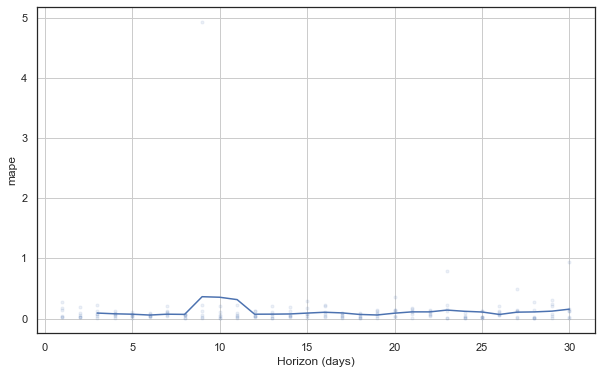

In [115]:
from prophet.plot import plot_cross_validation_metric

exp_df_cv = df_cv.copy()
exp_df_cv[['yhat', 'yhat_lower', 'yhat_upper', 'y']] = np.exp(exp_df_cv[['yhat', 'yhat_lower', 'yhat_upper', 'y']])
with sns.axes_style('white'):
    fig = plot_cross_validation_metric(exp_df_cv, metric='mape')

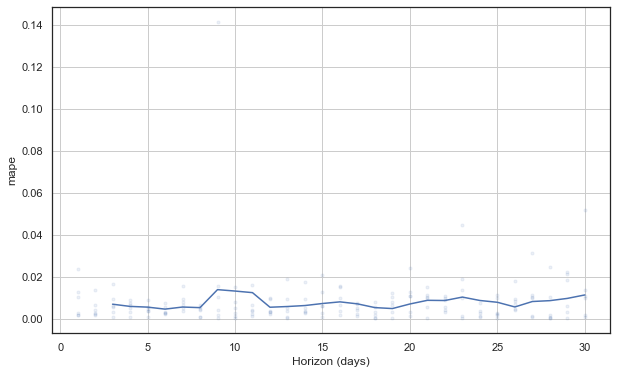

In [116]:
with sns.axes_style('white'):
    fig = plot_cross_validation_metric(df_cv, metric='mape')

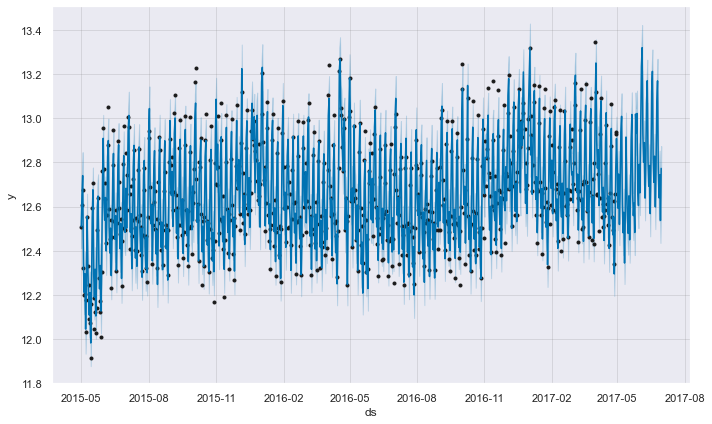

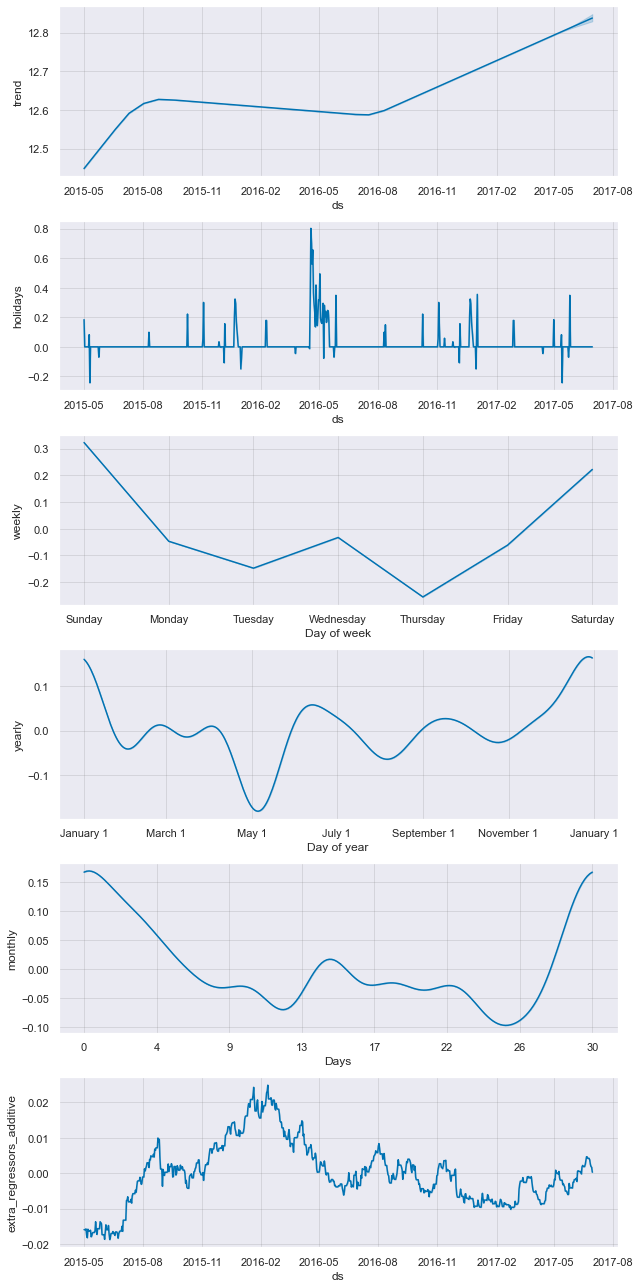

In [72]:
submodel = m.projection_model(['oil_price', 'tavg'])
submodel.fit(train)
forecast = submodel.predict(future)

fig1 = submodel.plot(forecast)
fig2 = submodel.plot_components(forecast)

In [117]:
pred_indices = future.index.values > m.history.index.max()
predictions = forecast.loc[
    pred_indices, 'yhat'].values
actual = future.loc[pred_indices, 'y'].values
mape = np.mean(np.abs((actual - predictions)/actual))
mape

0.017806114578853633

In [96]:
predictions

array([12.79717294, 12.59308698, 12.74770291, 12.51913885, 12.68298435,
       12.93761386, 13.00924625, 12.60893509, 12.48166984, 12.5743887 ,
       12.34428566, 12.54601798, 12.91553243, 12.67714867, 12.54357616,
       12.47854508, 12.64885622, 12.44953234, 12.62868349, 12.90400061,
       13.01772374, 12.658021  , 12.55907631, 12.61604958, 12.48276832,
       13.01947839, 12.93204528, 13.02234848, 12.6669493 , 12.60486329,
       12.79180052, 12.66254073, 12.93107261, 13.23609556, 13.32040254,
       12.92693291, 12.80090424, 12.89020295, 12.63854806, 12.80669965,
       13.07259638, 13.1706843 , 12.80507541, 12.69251305, 12.78620138,
       12.56826435, 12.8044706 , 13.12222916, 13.21315354, 12.81723765,
       12.71027364, 12.82884356, 12.59847031, 12.78512269, 13.07329944,
       13.16991725, 12.77226013, 12.63978299, 12.74464005, 12.53721436,
       12.7732917 ])

In [97]:
actual

array([13.18315395, 12.75912816, 12.7977085 , 12.50874774, 12.66861974,
       12.94105941, 13.10278967, 12.63321914, 12.48512438, 12.58302408,
       12.34849764, 12.60516271, 12.98839922, 12.74267879, 12.62417466,
       12.61613505, 12.7058631 , 12.37789545, 12.62869468, 12.9274345 ,
       13.10667444, 12.61815271, 12.50203338, 12.58162195, 12.35266247,
       12.87207628, 12.80306832, 12.95775042, 12.59243193, 12.5308632 ,
       12.69268551, 12.5963534 , 12.83062659, 13.08655994, 13.25837198,
       12.80171022, 12.61550996, 12.73562943, 12.42993334, 12.66740027,
       12.91126089, 13.11616692, 12.61041809, 12.52915178, 12.62591768,
       12.44229852, 12.73066688, 12.99521566, 12.84585831, 12.63758547,
       12.64866469, 12.62028069, 12.3625605 , 12.61573562, 12.87526188,
       12.99620938, 12.58329993, 12.43062005, 12.57461092, 12.36760652,
       12.68169673])

In [88]:
path = m.search(future)

        variable        kl
0      oil_price  0.124827
1   yellow_maize  0.152304
2           tavg  0.157497
3    onpromotion  0.177465
4  precipitation  0.179859
5           tmax  0.186933
6           tmin  0.187759
7       potatoes  0.192745
        variable        kl
0           tavg  0.074833
1   yellow_maize  0.107835
2    onpromotion  0.108372
3  precipitation  0.110436
4       potatoes  0.121416
5           tmax  0.123492
6           tmin  0.123912
        variable        kl
0  precipitation  0.034934
1   yellow_maize  0.053637
2    onpromotion  0.056864
3       potatoes  0.067296
4           tmax  0.069112
5           tmin  0.075213
       variable        kl
0   onpromotion  0.018847
1  yellow_maize  0.020333
2      potatoes  0.028699
3          tmax  0.030723
4          tmin  0.032079
       variable        kl
0  yellow_maize  0.004607
1      potatoes  0.013841
2          tmax  0.015346
3          tmin  0.017752
   variable        kl
0      tmax  0.000878
1      tmin  0.004071


In [104]:
path

{1: {'variables': ['oil_price'],
  'predictions':             ds       yhat  draw
  0   2015-05-01  12.329620     0
  1   2015-05-02  12.697017     0
  2   2015-05-03  12.750436     0
  3   2015-05-04  12.352630     0
  4   2015-05-05  12.259725     0
  ..         ...        ...   ...
  783 2017-06-26  12.952747     9
  784 2017-06-27  12.811521     9
  785 2017-06-28  12.962555     9
  786 2017-06-29  12.744413     9
  787 2017-06-30  12.953535     9
  
  [7880 rows x 3 columns],
  'mape': 0.01592750650642929},
 2: {'variables': ['oil_price', 'tavg'],
  'predictions':             ds       yhat  draw
  0   2015-05-01  12.262160     0
  1   2015-05-02  12.747820     0
  2   2015-05-03  12.765775     0
  3   2015-05-04  12.378234     0
  4   2015-05-05  12.282984     0
  ..         ...        ...   ...
  783 2017-06-26  12.997524     9
  784 2017-06-27  12.855833     9
  785 2017-06-28  12.930123     9
  786 2017-06-29  12.727035     9
  787 2017-06-30  12.946224     9
  
  [7880 rows x 

In [103]:
mapes = [step['mape'] for step in path.values()]
mapes

[0.01592750650642929,
 0.01605915423650691,
 0.016485370890932674,
 0.01615927671672238,
 0.0167852508988076,
 0.015819026224146458,
 0.01650755749774559,
 0.01627932358871789]

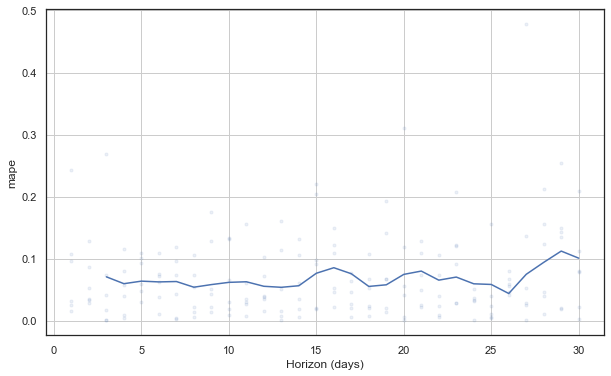

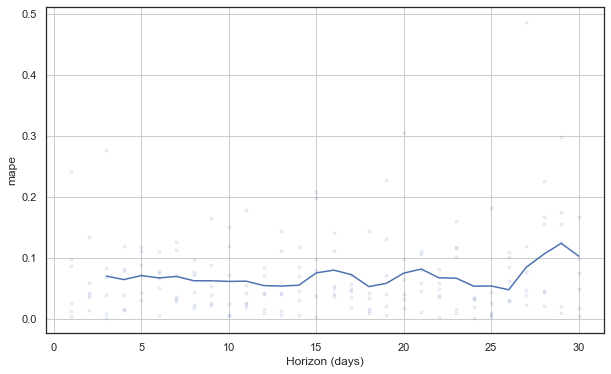

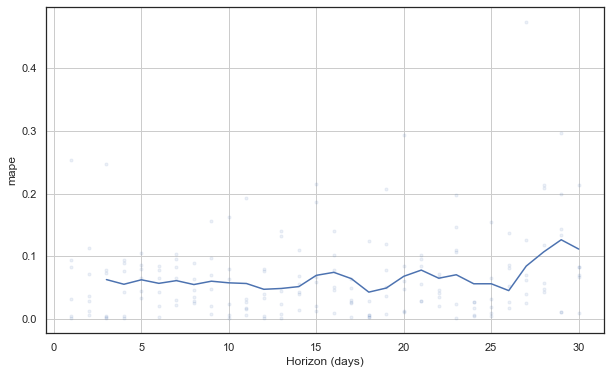

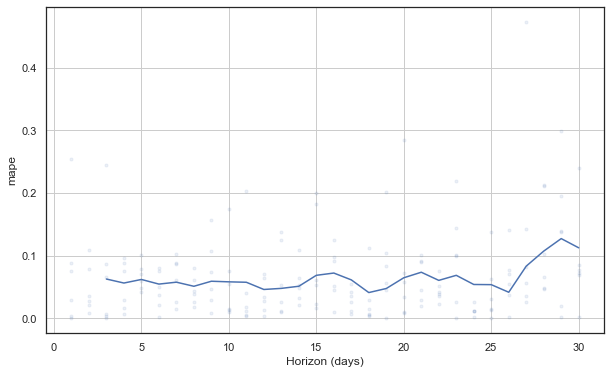

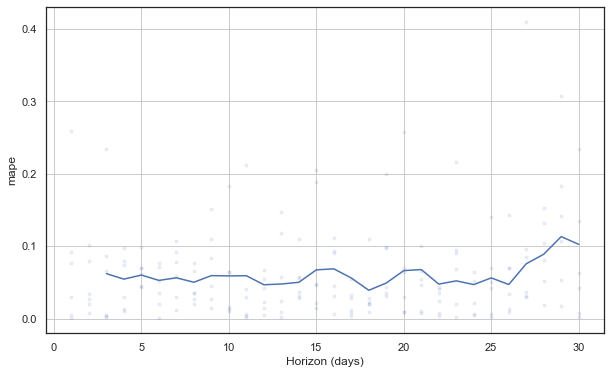

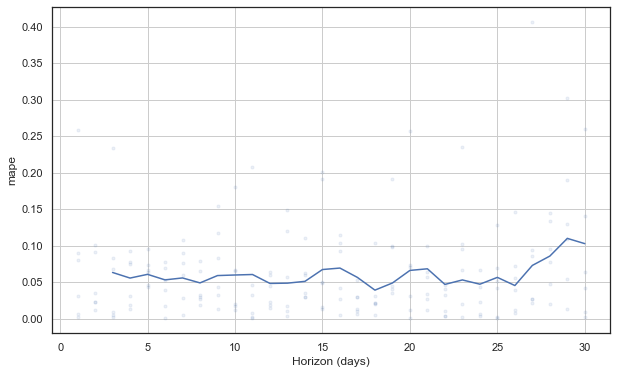

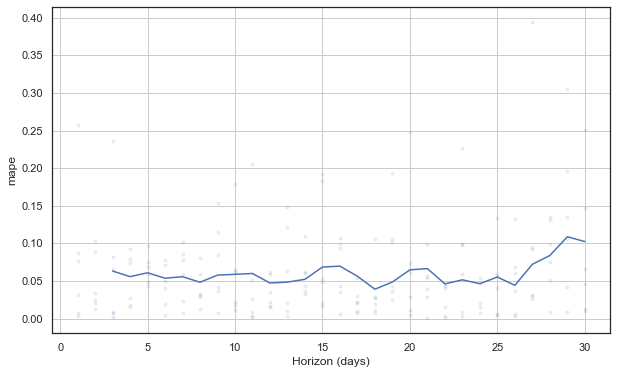

In [23]:
from prophet.plot import plot_cross_validation_metric
for cv in validations:
    exp_cv = cv.copy()
    exp_cv[['yhat', 'yhat_lower', 'yhat_upper', 'y']] = np.exp(exp_cv[['yhat', 'yhat_lower', 'yhat_upper', 'y']])
    #Measure performance relative to the original data (not reference predictions)
    exp_cv[['y']]=np.exp(df_cv[['y']])
    with sns.axes_style('white'):
        fig = plot_cross_validation_metric(exp_cv, metric='mape')

In [105]:
sf = submodel.stan_backend.stan_fit

In [132]:
msf = m.stan_backend.stan_fit

In [127]:
m.params

{'k': array([ 8.06780305e-02,  3.47367527e-03,  1.01624103e-02,  6.33385769e-02,
         7.60479083e-02,  3.76591014e-02,  5.77556157e-02,  3.55294645e-02,
         5.74869833e-02,  3.88383893e-02,  2.47844677e-02,  3.02950769e-02,
         6.57694389e-02,  3.45944338e-02,  4.41312200e-02,  8.31804422e-02,
         5.92433613e-02, -4.03509654e-03,  5.23056557e-02,  2.78360175e-02,
         3.51897336e-02,  2.21941868e-02,  6.79189080e-02, -4.37699837e-03,
         3.94076680e-02, -2.31949641e-02,  5.52463854e-03,  2.37258395e-02,
         7.06834777e-02,  9.75919445e-03,  2.25074313e-02,  4.93804255e-03,
         1.91226537e-02,  9.17025382e-02,  8.55826341e-02,  7.10349912e-02,
         4.82460503e-02,  5.27425099e-02,  3.31700398e-02,  2.92430016e-02,
         4.55799532e-02,  5.31001153e-02,  8.23323254e-02,  5.61793239e-02,
         5.97205997e-02,  6.37669967e-02,  3.08094200e-02,  6.95474766e-02,
         1.65708719e-02,  6.41023116e-02,  4.36299122e-02,  2.54017418e-03,
       

In [133]:
for value in m.params.values():
    print(value.shapeb)

(800,)
(800,)
(800, 25)
(800,)
(800, 125)
(800, 727)


In [138]:
dir(m.stan_fit)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '_call_sampler',
 '_get_param_dims',
 '_get_param_dims_oi',
 '_get_param_fnames_oi',
 '_get_param_names',
 '_get_param_names_oi',
 '_get_repr_num',
 '_get_repr_pars',
 '_repr_num',
 '_repr_pars',
 '_set_repr_num',
 '_set_repr_pars',
 '_update_param_oi',
 '_verify_has_samples',
 'constrain_pars',
 'constrained_param_names',
 'data',
 'date',
 'extract',
 'flatnames',
 'get_adaptation_info',
 'get_inits',
 'get_inv_metric',
 'get_last_position',
 'get_logposterior',
 'get_posterior_mean',
 'get_sampler_params',
 'get_seed',
 'get_stancode',
 'get_stanmodel',
 'get_stepsize',
 'grad_log_prob',
 'inits',

In [142]:
print(msf.get_stancode())

// Copyright (c) Facebook, Inc. and its affiliates.

// This source code is licensed under the MIT license found in the
// LICENSE file in the root directory of this source tree.

functions {
  matrix get_changepoint_matrix(vector t, vector t_change, int T, int S) {
    // Assumes t and t_change are sorted.
    matrix[T, S] A;
    row_vector[S] a_row;
    int cp_idx;

    // Start with an empty matrix.
    A = rep_matrix(0, T, S);
    a_row = rep_row_vector(0, S);
    cp_idx = 1;

    // Fill in each row of A.
    for (i in 1:T) {
      while ((cp_idx <= S) && (t[i] >= t_change[cp_idx])) {
        a_row[cp_idx] = 1;
        cp_idx = cp_idx + 1;
      }
      A[i] = a_row;
    }
    return A;
  }

  // Logistic trend functions

  vector logistic_gamma(real k, real m, vector delta, vector t_change, int S) {
    vector[S] gamma;  // adjusted offsets, for piecewise continuity
    vector[S + 1] k_s;  // actual rate in each segment
    real m_pr;

    // Compute the rate in each segment
    

In [137]:
m.uncertainty_samples

1000

In [135]:
msf.extract('sigma_obs')['sigma_obs'].shape

(800,)

In [136]:
msf.extract()

OrderedDict([('k',
              array([ 8.06780305e-02,  3.47367527e-03,  1.01624103e-02,  6.33385769e-02,
                      7.60479083e-02,  3.76591014e-02,  5.77556157e-02,  3.55294645e-02,
                      5.74869833e-02,  3.88383893e-02,  2.47844677e-02,  3.02950769e-02,
                      6.57694389e-02,  3.45944338e-02,  4.41312200e-02,  8.31804422e-02,
                      5.92433613e-02, -4.03509654e-03,  5.23056557e-02,  2.78360175e-02,
                      3.51897336e-02,  2.21941868e-02,  6.79189080e-02, -4.37699837e-03,
                      3.94076680e-02, -2.31949641e-02,  5.52463854e-03,  2.37258395e-02,
                      7.06834777e-02,  9.75919445e-03,  2.25074313e-02,  4.93804255e-03,
                      1.91226537e-02,  9.17025382e-02,  8.55826341e-02,  7.10349912e-02,
                      4.82460503e-02,  5.27425099e-02,  3.31700398e-02,  2.92430016e-02,
                      4.55799532e-02,  5.31001153e-02,  8.23323254e-02,  5.61793239e-02,
  

In [67]:
m.predictive_samples(future)['yhat'][:,0]

array([12.5052465 , 12.58970851, 12.71270611, 12.34572775, 12.3426334 ,
       12.10821423, 11.992621  , 12.2564372 , 12.3760646 , 12.15476531,
       12.04170356, 12.06524984, 12.12969114, 11.94035575, 12.2067551 ,
       12.44328368, 12.72654411, 12.31649061, 12.13458595, 12.23219733,
       12.10510663, 12.31285925, 12.5314569 , 12.62428283, 12.31415233,
       12.05010635, 12.31150804, 12.09628857, 12.38527742, 12.83909204,
       12.82102663, 12.66279171, 12.60123982, 12.56303812, 12.31838014,
       12.63421804, 12.74191293, 13.05325081, 12.49786302, 12.35987594,
       12.40132693, 12.25055103, 12.39261367, 12.85731194, 12.77030862,
       12.43108059, 12.38505203, 12.65422704, 12.35732145, 12.43217458,
       12.81583592, 12.81609601, 12.49841925, 12.21954251, 12.46853233,
       12.21558722, 12.29544627, 12.62451381, 12.86433565, 12.52135581,
       12.40516323, 12.76752548, 12.54537078, 12.84175858, 12.942593  ,
       13.04038141, 12.51422111, 12.45693342, 12.5411156 , 12.37